In [14]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
wel = pd.read_pickle('../../data/trimmed_processed/WELFake.pkl')
isot = pd.read_pickle('../../data/trimmed_processed/FAKE-REAL.pkl')
ind = pd.read_pickle('../../data/trimmed_processed/Indian.pkl')


In [16]:
df = pd.concat([wel,isot,ind])
df.shape
df['label'].value_counts()

label
FAKE    60386
REAL    60375
Name: count, dtype: int64

In [4]:
x = df['text'].astype(str)
y = df['label']

x_train, x_test, y_train, y_test = train_test_split(
    x,y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [5]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=25000,
    max_df=0.8,
    ngram_range=(1,2)
)

x_train_idf = tfidf.fit_transform(x_train)
x_test_idf = tfidf.transform(x_test)

In [6]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(x_train_idf,y_train)

y_pred = clf.predict(x_test_idf)

              precision    recall  f1-score   support

        FAKE     0.5774    0.5734    0.5754     12078
        REAL     0.5762    0.5803    0.5783     12075

    accuracy                         0.5768     24153
   macro avg     0.5768    0.5768    0.5768     24153
weighted avg     0.5768    0.5768    0.5768     24153



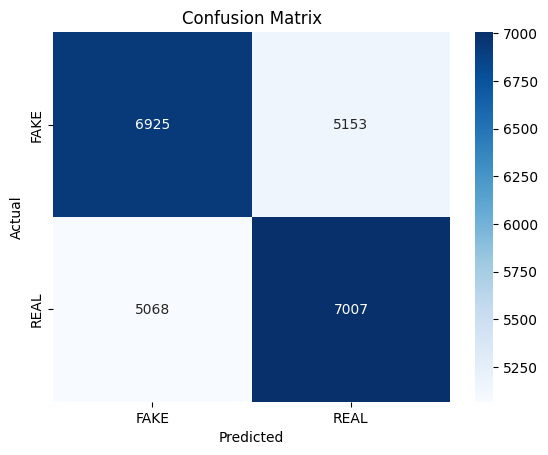

In [7]:
print(classification_report(y_test,y_pred, digits=4))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=clf.classes_,yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from collections import Counter
import re

class FakeNewsModelDiagnostics:
    def __init__(self, texts, labels, predictions=None, model=None):
        self.texts = texts
        self.labels = labels
        self.predictions = predictions
        self.model = model
    
    def dataset_quality_check(self):
        """Comprehensive dataset quality analysis"""
        print("=== DATASET QUALITY ANALYSIS ===\n")
        
        # Basic statistics
        print(f"Total samples: {len(self.texts):,}")
        print(f"Unique texts: {len(set(self.texts)):,}")
        print(f"Duplicate rate: {(1 - len(set(self.texts))/len(self.texts))*100:.2f}%")
        
        # Label distribution
        label_counts = Counter(self.labels)
        print(f"\nLabel distribution:")
        for label, count in label_counts.items():
            label_name = 'FAKE' if label == 0 else 'REAL'
            print(f"  {label_name}: {count:,} ({count/len(self.labels)*100:.1f}%)")
        
        # Text length analysis
        word_counts = [len(text.split()) for text in self.texts]
        char_counts = [len(text) for text in self.texts]
        
        print(f"\nText length statistics:")
        print(f"  Word count - Mean: {np.mean(word_counts):.1f}, Median: {np.median(word_counts):.1f}")
        print(f"  Word count - Min: {np.min(word_counts)}, Max: {np.max(word_counts)}")
        print(f"  Char count - Mean: {np.mean(char_counts):.1f}, Median: {np.median(char_counts):.1f}")
        
        # Identify problematic samples
        very_short = sum(1 for wc in word_counts if wc < 10)
        very_long = sum(1 for wc in word_counts if wc > 2000)
        print(f"  Very short (<10 words): {very_short} ({very_short/len(self.texts)*100:.2f}%)")
        print(f"  Very long (>2000 words): {very_long} ({very_long/len(self.texts)*100:.2f}%)")
        
        return {
            'word_counts': word_counts,
            'char_counts': char_counts,
            'duplicates': len(self.texts) - len(set(self.texts)),
            'very_short': very_short,
            'very_long': very_long
        }
    
    def analyze_misclassifications(self):
        """Analyze patterns in misclassified samples"""
        if self.predictions is None:
            print("No predictions provided for misclassification analysis")
            return
        
        print("\n=== MISCLASSIFICATION ANALYSIS ===\n")
        
        # Get misclassified indices
        wrong_indices = np.where(self.predictions != self.labels)[0]
        false_positives = np.where((self.predictions == 1) & (self.labels == 0))[0]  # Predicted REAL, actually FAKE
        false_negatives = np.where((self.predictions == 0) & (self.labels == 1))[0]  # Predicted FAKE, actually REAL
        
        print(f"Total misclassifications: {len(wrong_indices):,} ({len(wrong_indices)/len(self.labels)*100:.1f}%)")
        print(f"False Positives: {len(false_positives):,} (Real news classified as fake)")
        print(f"False Negatives: {len(false_negatives):,} (Fake news classified as real)")
        
        # Analyze text characteristics of misclassified samples
        def analyze_text_group(indices, group_name):
            if len(indices) == 0:
                return
            
            group_texts = [self.texts[i] for i in indices]
            word_counts = [len(text.split()) for text in group_texts]
            
            print(f"\n{group_name}:")
            print(f"  Average length: {np.mean(word_counts):.1f} words")
            print(f"  Length range: {np.min(word_counts)} - {np.max(word_counts)} words")
            
            # Show sample misclassifications
            print(f"  Sample texts:")
            for i in range(min(3, len(indices))):
                text_preview = group_texts[i][:200] + "..." if len(group_texts[i]) > 200 else group_texts[i]
                print(f"    - {text_preview}")
        
        analyze_text_group(false_positives, "False Positives (Predicted REAL, Actually FAKE)")
        analyze_text_group(false_negatives, "False Negatives (Predicted FAKE, Actually REAL)")
    
    def content_pattern_analysis(self):
        """Analyze content patterns between fake and real news"""
        print("\n=== CONTENT PATTERN ANALYSIS ===\n")
        
        fake_texts = [self.texts[i] for i, label in enumerate(self.labels) if label == 0]
        real_texts = [self.texts[i] for i, label in enumerate(self.labels) if label == 1]
        
        def analyze_group_patterns(texts, group_name):
            print(f"{group_name} News Patterns:")
            
            # Length patterns
            word_counts = [len(text.split()) for text in texts]
            print(f"  Average length: {np.mean(word_counts):.1f} words")
            
            # Punctuation patterns
            exclamation_ratio = np.mean([text.count('!') / max(len(text), 1) for text in texts])
            question_ratio = np.mean([text.count('?') / max(len(text), 1) for text in texts])
            caps_ratio = np.mean([sum(c.isupper() for c in text) / max(len(text), 1) for text in texts])
            
            print(f"  Exclamation ratio: {exclamation_ratio:.4f}")
            print(f"  Question ratio: {question_ratio:.4f}")
            print(f"  Capitals ratio: {caps_ratio:.4f}")
            
            # Common words
            all_words = ' '.join(texts).lower().split()
            word_freq = Counter(all_words)
            common_words = word_freq.most_common(10)
            print(f"  Most common words: {[word for word, freq in common_words[:5]]}")
            
        analyze_group_patterns(fake_texts, "FAKE")
        print()
        analyze_group_patterns(real_texts, "REAL")
    
    def suggest_improvements(self):
        """Provide targeted improvement suggestions"""
        print("\n=== IMPROVEMENT SUGGESTIONS ===\n")
        
        stats = self.dataset_quality_check()
        
        suggestions = []
        
        # Data quality issues
        if stats['duplicates'] > len(self.texts) * 0.05:
            suggestions.append("🔍 Remove duplicate articles - they may cause overfitting")
        
        if stats['very_short'] > len(self.texts) * 0.05:
            suggestions.append("📝 Consider removing very short articles (<10 words) - insufficient content for classification")
        
        if stats['very_long'] > len(self.texts) * 0.05:
            suggestions.append("✂️ Consider truncating very long articles or using hierarchical attention")
        
        # Performance-based suggestions
        suggestions.extend([
            "🧠 Try ensemble methods (Random Forest + XGBoost + Logistic Regression)",
            "📊 Use TF-IDF with character n-grams (1-4 chars) - captures stylistic differences",
            "🎯 Add domain-specific features (sensational words, bias indicators, source mentions)",
            "🔄 Use stratified cross-validation to ensure consistent performance",
            "⚖️ Consider class weighting if dataset is imbalanced",
            "🤖 Try pre-trained embeddings (BERT, RoBERTa) for semantic understanding",
            "🔍 Implement feature selection to reduce noise",
            "📈 Use learning curves to check for overfitting/underfitting"
        ])
        
        for i, suggestion in enumerate(suggestions, 1):
            print(f"{i}. {suggestion}")
    
    def plot_performance_analysis(self):
        """Create visualizations for performance analysis"""
        if self.predictions is None:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Confusion matrix
        cm = confusion_matrix(self.labels, self.predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
        axes[0,0].set_title('Confusion Matrix')
        axes[0,0].set_xlabel('Predicted')
        axes[0,0].set_ylabel('Actual')
        
        # Length distribution by class
        fake_lengths = [len(self.texts[i].split()) for i, label in enumerate(self.labels) if label == 0]
        real_lengths = [len(self.texts[i].split()) for i, label in enumerate(self.labels) if label == 1]
        
        axes[0,1].hist([fake_lengths, real_lengths], bins=50, alpha=0.7, label=['Fake', 'Real'])
        axes[0,1].set_title('Text Length Distribution by Class')
        axes[0,1].set_xlabel('Word Count')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].legend()
        
        # Misclassification length analysis
        if self.predictions is not None:
            correct_indices = np.where(self.predictions == self.labels)[0]
            wrong_indices = np.where(self.predictions != self.labels)[0]
            
            correct_lengths = [len(self.texts[i].split()) for i in correct_indices]
            wrong_lengths = [len(self.texts[i].split()) for i in wrong_indices]
            
            axes[1,0].hist([correct_lengths, wrong_lengths], bins=50, alpha=0.7, 
                          label=['Correct', 'Misclassified'])
            axes[1,0].set_title('Length Distribution: Correct vs Misclassified')
            axes[1,0].set_xlabel('Word Count')
            axes[1,0].set_ylabel('Frequency')
            axes[1,0].legend()
        
        # Class distribution
        label_counts = Counter(self.labels)
        axes[1,1].bar(['Fake', 'Real'], [label_counts[0], label_counts[1]])
        axes[1,1].set_title('Class Distribution')
        axes[1,1].set_ylabel('Count')
        
        plt.tight_layout()
        plt.show()

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

class AlgorithmComparison:
    def __init__(self, X_texts, y_labels, test_size=0.2, random_state=42):
        self.X_texts = X_texts
        self.y_labels = y_labels
        self.test_size = test_size
        self.random_state = random_state
        self.results = {}
        
    def create_models(self):
        """Create different model pipelines for comparison"""
        
        # Common TF-IDF parameters
        tfidf_params = {
            'ngram_range': (1, 3),
            'max_features': 10000,
            'min_df': 2,
            'max_df': 0.95,
            'stop_words': 'english'
        }
        
        models = {
            'Logistic Regression': Pipeline([
                ('tfidf', TfidfVectorizer(**tfidf_params)),
                ('classifier', LogisticRegression(C=1.0, max_iter=1000, random_state=self.random_state))
            ]),
            
            'SVM Linear': Pipeline([
                ('tfidf', TfidfVectorizer(**tfidf_params)),
                ('classifier', SVC(kernel='linear', C=1.0, random_state=self.random_state))
            ]),
            
            'SVM RBF': Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000, min_df=2, max_df=0.95, stop_words='english')),
                ('classifier', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=self.random_state))
            ]),
            
            'Naive Bayes (Multinomial)': Pipeline([
                ('tfidf', TfidfVectorizer(**tfidf_params)),
                ('classifier', MultinomialNB(alpha=0.1))
            ]),
            
            'Naive Bayes (Complement)': Pipeline([
                ('tfidf', TfidfVectorizer(**tfidf_params)),
                ('classifier', ComplementNB(alpha=0.1))
            ]),
            
            'Random Forest': Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000, min_df=2, max_df=0.95, stop_words='english')),
                ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=self.random_state))
            ])
        }
        
        return models
    
    def compare_algorithms(self, cv_folds=5):
        """Compare all algorithms using cross-validation"""
        
        models = self.create_models()
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        
        print("🔄 Running Algorithm Comparison...")
        print("=" * 80)
        
        results = []
        
        for name, model in models.items():
            print(f"\nTesting {name}...")
            
            start_time = time.time()
            
            # Cross-validation scores
            cv_scores = cross_val_score(
                model, self.X_texts, self.y_labels, 
                cv=skf, scoring='accuracy', n_jobs=-1
            )
            
            f1_scores = cross_val_score(
                model, self.X_texts, self.y_labels, 
                cv=skf, scoring='f1_macro', n_jobs=-1
            )
            
            training_time = time.time() - start_time
            
            result = {
                'Algorithm': name,
                'Mean Accuracy': cv_scores.mean(),
                'Std Accuracy': cv_scores.std(),
                'Mean F1-Score': f1_scores.mean(),
                'Std F1-Score': f1_scores.std(),
                'Training Time (s)': training_time,
                'CV Scores': cv_scores
            }
            
            results.append(result)
            
            print(f"  ✅ Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
            print(f"  ✅ F1-Score: {f1_scores.mean():.4f} (±{f1_scores.std()*2:.4f})")
            print(f"  ⏱️  Time: {training_time:.2f}s")
        
        # Sort by accuracy
        results.sort(key=lambda x: x['Mean Accuracy'], reverse=True)
        
        self.results = results
        return results
    
    def print_summary(self):
        """Print a comprehensive summary of results"""
        
        if not self.results:
            print("No results available. Run compare_algorithms() first.")
            return
        
        print("\n" + "🏆 FINAL RANKINGS" + "\n")
        print("=" * 80)
        
        df = pd.DataFrame([
            {
                'Rank': i+1,
                'Algorithm': result['Algorithm'],
                'Accuracy': f"{result['Mean Accuracy']:.4f} ±{result['Std Accuracy']*2:.4f}",
                'F1-Score': f"{result['Mean F1-Score']:.4f} ±{result['Std F1-Score']*2:.4f}",
                'Time (s)': f"{result['Training Time (s)']:.1f}"
            }
            for i, result in enumerate(self.results)
        ])
        
        print(df.to_string(index=False))
        
        # Best performer analysis
        best = self.results[0]
        print(f"\n🥇 BEST PERFORMER: {best['Algorithm']}")
        print(f"   Accuracy: {best['Mean Accuracy']:.4f} (±{best['Std Accuracy']*2:.4f})")
        print(f"   F1-Score: {best['Mean F1-Score']:.4f} (±{best['Std F1-Score']*2:.4f})")
        
        # Improvement analysis
        if len(self.results) > 1:
            baseline = next((r for r in self.results if 'Logistic' in r['Algorithm']), self.results[-1])
            improvement = best['Mean Accuracy'] - baseline['Mean Accuracy']
            print(f"\n📈 IMPROVEMENT OVER BASELINE:")
            print(f"   +{improvement:.4f} accuracy (+{improvement*100:.2f}%)")
        
        return df
    
    def get_best_model(self):
        """Return the best performing model"""
        if not self.results:
            print("No results available. Run compare_algorithms() first.")
            return None
        
        best_name = self.results[0]['Algorithm']
        models = self.create_models()
        return models[best_name]
    
    def detailed_analysis(self, top_n=3):
        """Provide detailed analysis of top performers"""
        
        if not self.results:
            print("No results available. Run compare_algorithms() first.")
            return
        
        print(f"\n🔍 DETAILED ANALYSIS - TOP {top_n} PERFORMERS")
        print("=" * 80)
        
        for i, result in enumerate(self.results[:top_n]):
            print(f"\n{i+1}. {result['Algorithm']}")
            print(f"   📊 Individual CV Scores: {[f'{score:.4f}' for score in result['CV Scores']]}")
            print(f"   📈 Best CV Score: {max(result['CV Scores']):.4f}")
            print(f"   📉 Worst CV Score: {min(result['CV Scores']):.4f}")
            print(f"   🎯 Consistency: {'High' if result['Std Accuracy'] < 0.01 else 'Medium' if result['Std Accuracy'] < 0.02 else 'Low'}")
            
            # Performance insights
            if 'SVM' in result['Algorithm']:
                print(f"   💡 Insight: SVM excels with high-dimensional sparse text data")
            elif 'Naive Bayes' in result['Algorithm']:
                print(f"   💡 Insight: Fast and effective for text classification, assumes feature independence")
            elif 'Logistic' in result['Algorithm']:
                print(f"   💡 Insight: Good baseline, interpretable coefficients")
            elif 'Random Forest' in result['Algorithm']:
                print(f"   💡 Insight: Handles feature interactions, less interpretable")

# Quick Algorithm Comparison - Ready to Run
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
import time
import numpy as np

def quick_algorithm_comparison(texts, labels, cv_folds=5):
    """
    Quick comparison of different algorithms
    Replace 'texts' and 'labels' with your actual data variables
    """
    
    print("🚀 Starting Quick Algorithm Comparison...")
    print("=" * 60)
    
    # Define models to test
    models = {
        'Logistic Regression': Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000, stop_words='english')),
            ('clf', LogisticRegression(C=1.0, max_iter=1000))
        ]),
        
        'SVM Linear': Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=(1,3), max_features=10000, stop_words='english')),
            ('clf', SVC(kernel='linear', C=1.0))
        ]),
        
        'SVM RBF': Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')),
            ('clf', SVC(kernel='rbf', C=1.0, gamma='scale'))
        ]),
        
        'Naive Bayes': Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000, stop_words='english')),
            ('clf', MultinomialNB(alpha=0.1))
        ]),
        
        'Random Forest': Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')),
            ('clf', RandomForestClassifier(n_estimators=50, max_depth=10))
        ])
    }
    
    results = []
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"\n🔄 Testing {name}...")
        
        start_time = time.time()
        
        try:
            # Cross-validation
            accuracy_scores = cross_val_score(model, texts, labels, cv=skf, scoring='accuracy', n_jobs=-1)
            f1_scores = cross_val_score(model, texts, labels, cv=skf, scoring='f1_macro', n_jobs=-1)
            
            elapsed_time = time.time() - start_time
            
            results.append({
                'Algorithm': name,
                'Accuracy': accuracy_scores.mean(),
                'Accuracy_Std': accuracy_scores.std(),
                'F1_Score': f1_scores.mean(),
                'F1_Std': f1_scores.std(),
                'Time': elapsed_time
            })
            
            print(f"   ✅ Accuracy: {accuracy_scores.mean():.4f} (±{accuracy_scores.std()*2:.4f})")
            print(f"   ✅ F1-Score: {f1_scores.mean():.4f} (±{f1_scores.std()*2:.4f})")
            print(f"   ⏱️  Time: {elapsed_time:.1f}s")
            
        except Exception as e:
            print(f"   ❌ Error: {str(e)}")
            continue
    
    # Sort by accuracy
    results.sort(key=lambda x: x['Accuracy'], reverse=True)
    
    print("\n" + "🏆 FINAL RANKINGS" + "\n")
    print("=" * 70)
    print(f"{'Rank':<4} {'Algorithm':<18} {'Accuracy':<12} {'F1-Score':<12} {'Time':<8}")
    print("-" * 70)
    
    for i, result in enumerate(results):
        print(f"{i+1:<4} {result['Algorithm']:<18} "
              f"{result['Accuracy']:.4f}±{result['Accuracy_Std']*2:.3f} "
              f"{result['F1_Score']:.4f}±{result['F1_Std']*2:.3f} "
              f"{result['Time']:.1f}s")
    
    if results:
        best = results[0]
        print(f"\n🥇 WINNER: {best['Algorithm']}")
        print(f"   📈 Accuracy: {best['Accuracy']:.4f}")
        print(f"   🎯 F1-Score: {best['F1_Score']:.4f}")
        
        # Calculate improvement over your current result (57.68%)
        current_accuracy = 0.5768  # Your current result
        improvement = best['Accuracy'] - current_accuracy
        improvement_pct = (improvement / current_accuracy) * 100
        
        if improvement > 0:
            print(f"   🚀 Improvement: +{improvement:.4f} (+{improvement_pct:.1f}%)")
        else:
            print(f"   ⚠️  Change: {improvement:.4f} ({improvement_pct:.1f}%)")
    
    return results

# USAGE:
# Replace 'your_texts' and 'your_labels' with your actual variable names
# results = quick_algorithm_comparison(your_texts, your_labels)

# Example with common variable names:
# results = quick_algorithm_comparison(texts, labels)
# or
# results = quick_algorithm_comparison(X_text, y)

print("📝 TO RUN: Replace the variable names below and execute:")
print("results = quick_algorithm_comparison(texts, labels)")
print("\nMake sure your text data variable contains the raw text strings,")
print("not the already vectorized features!")


# Initialize comparison with your data
comparison = AlgorithmComparison(df['text'], df['label'])

# Run the actual comparison (this will take a few minutes)
results = comparison.compare_algorithms(cv_folds=5)

# Print the results
comparison.print_summary()

# Get detailed analysis of top performers
comparison.detailed_analysis()


📝 TO RUN: Replace the variable names below and execute:
results = quick_algorithm_comparison(texts, labels)

Make sure your text data variable contains the raw text strings,
not the already vectorized features!
🔄 Running Algorithm Comparison...

Testing Logistic Regression...


KeyboardInterrupt: 

In [17]:
# Simple Algorithm Test - Memory Efficient
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import time

def test_single_algorithm(texts, labels, algorithm='svm', test_size=0.2):
    """Test a single algorithm efficiently"""
    
    print(f"🧪 Testing {algorithm.upper()}...")
    print(f"📊 Dataset size: {len(texts):,} samples")
    
    # Split data first to reduce memory usage
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    print(f"📈 Training size: {len(X_train):,}")
    print(f"🎯 Test size: {len(X_test):,}")
    
    # Define model based on algorithm choice
    if algorithm.lower() == 'svm':
        model = Pipeline([
            ('tfidf', TfidfVectorizer(
                ngram_range=(1,3), 
                max_features=8000,  # Reduced for memory
                min_df=3,
                max_df=0.95,
                stop_words='english'
            )),
            ('classifier', SVC(kernel='linear', C=1.0))
        ])
        
    elif algorithm.lower() == 'nb':
        model = Pipeline([
            ('tfidf', TfidfVectorizer(
                ngram_range=(1,2), 
                max_features=8000,
                min_df=3,
                max_df=0.95,
                stop_words='english'
            )),
            ('classifier', MultinomialNB(alpha=0.1))
        ])
        
    elif algorithm.lower() == 'lr':
        model = Pipeline([
            ('tfidf', TfidfVectorizer(
                ngram_range=(1,2), 
                max_features=8000,
                min_df=3,
                max_df=0.95,
                stop_words='english'
            )),
            ('classifier', LogisticRegression(C=1.0, max_iter=1000))
        ])
    
    else:
        raise ValueError("Algorithm must be 'svm', 'nb', or 'lr'")
    
    # Train and test
    start_time = time.time()
    
    print("🔄 Training...")
    model.fit(X_train, y_train)
    
    print("🔄 Predicting...")
    y_pred = model.predict(X_test)
    
    training_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n✅ RESULTS for {algorithm.upper()}:")
    print(f"   🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   ⏱️  Training time: {training_time:.1f}s")
    
    # Compare with your baseline (57.68%)
    baseline = 0.5768
    improvement = accuracy - baseline
    improvement_pct = (improvement / baseline) * 100
    
    if improvement > 0:
        print(f"   📈 Improvement: +{improvement:.4f} (+{improvement_pct:.1f}%)")
    else:
        print(f"   📉 Change: {improvement:.4f} ({improvement_pct:.1f}%)")
    
    # Detailed classification report
    print(f"\n📊 Detailed Report:")
    print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))
    
    return {
        'algorithm': algorithm,
        'accuracy': accuracy,
        'improvement': improvement,
        'training_time': training_time,
        'model': model
    }

def quick_comparison(texts, labels):
    """Test multiple algorithms one by one to avoid memory issues"""
    
    algorithms = ['lr', 'svm', 'nb']
    results = []
    
    print("🚀 Quick Algorithm Comparison (Sequential)")
    print("=" * 60)
    
    for algo in algorithms:
        try:
            result = test_single_algorithm(texts, labels, algo)
            results.append(result)
            print("\n" + "-" * 60)
        except Exception as e:
            print(f"❌ Error with {algo}: {str(e)}")
            continue
    
    # Summary
    if results:
        print("\n🏆 SUMMARY:")
        results.sort(key=lambda x: x['accuracy'], reverse=True)
        
        for i, result in enumerate(results):
            symbol = "🥇" if i == 0 else "🥈" if i == 1 else "🥉"
            print(f"{symbol} {result['algorithm'].upper()}: {result['accuracy']:.4f} "
                  f"(+{result['improvement']:.4f})")
    
    return results

# USAGE EXAMPLES:

# Test just SVM (recommended first):
print("💡 RECOMMENDED: Test SVM first (usually best for text)")
print("result = test_single_algorithm(df['text'], df['label'], 'svm')")

# Test all three:
print("\n💡 To test all algorithms:")  
print("results = quick_comparison(df['text'], df['label'])")

print("\n🔧 If you still get memory errors:")
print("1. Use a smaller sample: df.sample(n=5000)")
print("2. Reduce max_features in TfidfVectorizer")
print("3. Use fewer n-grams")

💡 RECOMMENDED: Test SVM first (usually best for text)
result = test_single_algorithm(df['text'], df['label'], 'svm')

💡 To test all algorithms:
results = quick_comparison(df['text'], df['label'])

🔧 If you still get memory errors:
1. Use a smaller sample: df.sample(n=5000)
2. Reduce max_features in TfidfVectorizer
3. Use fewer n-grams


In [11]:
# Step 1: Test SVM first (most likely to improve)
result_svm = test_single_algorithm(df['text'], df['label'], 'svm')

NameError: name 'df' is not defined

In [18]:
# Use a smaller sample to test
sample_df = df.sample(n=5000, random_state=42)
result_svm = test_single_algorithm(sample_df['text'], sample_df['label'], 'svm')

🧪 Testing SVM...
📊 Dataset size: 5,000 samples
📈 Training size: 4,000
🎯 Test size: 1,000
🔄 Training...
🔄 Predicting...

✅ RESULTS for SVM:
   🎯 Accuracy: 0.5890 (58.90%)
   ⏱️  Training time: 34.0s
   📈 Improvement: +0.0122 (+2.1%)

📊 Detailed Report:
              precision    recall  f1-score   support

        FAKE       0.60      0.58      0.59       506
        REAL       0.58      0.60      0.59       494

    accuracy                           0.59      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.59      0.59      0.59      1000



In [ ]:
# Test all algorithms (one at a time to avoid memory issues)
results = quick_comparison(df['text'], df['label'])

🚀 Quick Algorithm Comparison (Sequential)
🧪 Testing LR...
📊 Dataset size: 120,761 samples
📈 Training size: 96,608
🎯 Test size: 24,153
🔄 Training...
🔄 Predicting...

✅ RESULTS for LR:
   🎯 Accuracy: 0.5978 (59.78%)
   ⏱️  Training time: 129.5s
   📈 Improvement: +0.0210 (+3.6%)

📊 Detailed Report:
              precision    recall  f1-score   support

        FAKE       0.60      0.59      0.60     12078
        REAL       0.60      0.60      0.60     12075

    accuracy                           0.60     24153
   macro avg       0.60      0.60      0.60     24153
weighted avg       0.60      0.60      0.60     24153


------------------------------------------------------------
🧪 Testing SVM...
📊 Dataset size: 120,761 samples
📈 Training size: 96,608
🎯 Test size: 24,153
🔄 Training...
